In this tutorial, we will explore the basic concepts of accessing scroll data, image processing the resulting numpy arrays, and extracting a small portion of the scroll surface (a step called "segmentation").

## Notebook overview:
1. **Scroll data access**\
Start by fetching the necessary scroll data.
2. **Volume slices**\
Accessing and viewing particular slices.
3. **Volume chunks**\
Viewing and then processing a small scroll chunk to create a histogram of intensity values.
4. **Segmentation proof of concept**\
Advanced - skip if not interested in surface segmentation. Note that segmenting a full scroll is more complicated!

## 1. Scroll data access
First, we need to install the `vesuvius` package, which will help us quickly fetch the scroll data from the repository:

In [ ]:
!pip install vesuvius
!vesuvius.accept_terms --yes

Then we can import it into Python:

In [ ]:
import vesuvius
from vesuvius import Volume

!pip install matplotlib
from matplotlib import pyplot as plt

Great! Here's the next step for initializing a `Volume` object using [Scroll 1](https://scrollprize.org/data_scrolls). The default (or "canonical") volume was scanned at 54keV and 7.91um resolution.

We can load the canonical volume by just prompting "Scroll1" or by specifying the scan metadata.

In [7]:
# Initialize Scroll 1 volume
scroll = Volume("Scroll1")

# Equivalent:
# scroll = Volume(type="scroll", scroll_id=1, energy=54, resolution=7.91)

# View Volume metadata (list the downsampled resolutions that are available)
scroll.meta()

Data with original resolution: 7.91 um, subvolume idx: 0, shape: (14376, 7888, 8096)
Contains also data with scaled resolution: 15.82 um, subvolume idx: 1, shape: (7188, 3944, 4048)
Contains also data with scaled resolution: 31.64 um, subvolume idx: 2, shape: (3594, 1972, 2024)
Contains also data with scaled resolution: 63.28 um, subvolume idx: 3, shape: (1797, 986, 1012)
Contains also data with scaled resolution: 126.56 um, subvolume idx: 4, shape: (899, 493, 506)
Contains also data with scaled resolution: 253.12 um, subvolume idx: 5, shape: (450, 247, 253)


`scroll` is a `Volume` object that points to the Scroll 1 volume scanned at 54 keV and 7.91 um on our online repository. It contains the full resolution volume as well as downsampled versions of it. We can access the data as if it were a numpy array. When we provide just three indices, we will index into the full resolution volume. The optional fourth index specifies the downsampled volume to use, in which case the first three indices will refer to a smaller region of the volume. The volume is indexed with the following convention: [z, y, x].

## 2. Volume slices
Let's take a look at a single slice (z=1000 in the downsampled 63.28 um volume):

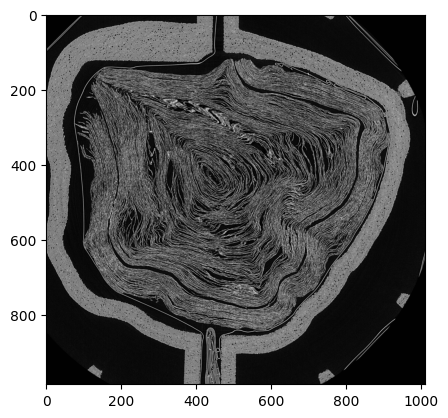

In [27]:
# Visualizing a full slice of the volume downsampled at 63.28 um
plt.imshow(scroll[1000,:,:,3], cmap='gray')

We can see a scroll cross section in the middle of the image, showing the rolled up papyrus layers. This is surrounded by a thick line that is the plastic wall of the 3D printed case holding the scroll. The dark regions are empty (air).

Let us visualize multiple z-slices:

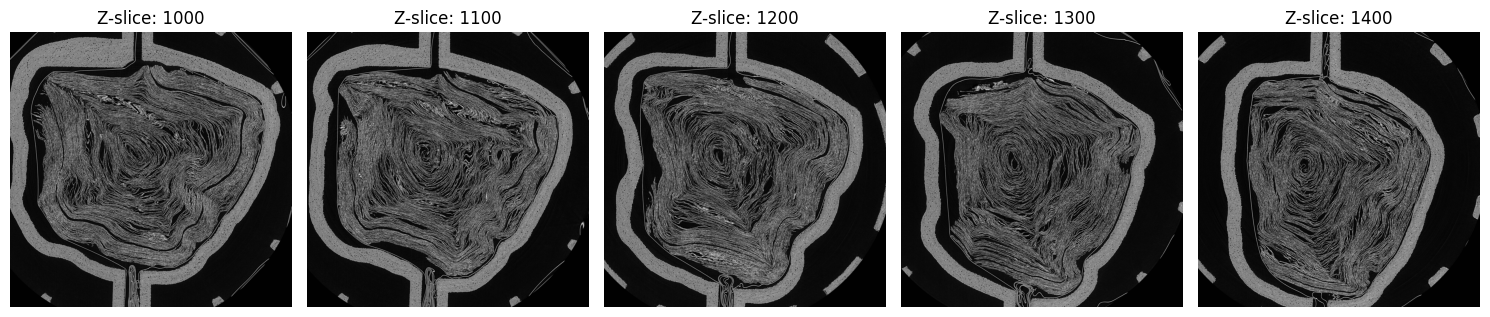

In [9]:
# Set the starting slice and the number of slices to display
slice_index = 1000
num_slices = 5  # Number of slices to display side by side

# Create a figure with subplots
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Plot each slice side by side
for i in range(num_slices):
    current_slice = slice_index + 100*i
    axes[i].imshow(scroll[current_slice, :, :, 3], cmap='gray')
    axes[i].set_title(f'Z-slice: {current_slice}')
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

Let's do the same for a sagittal view!

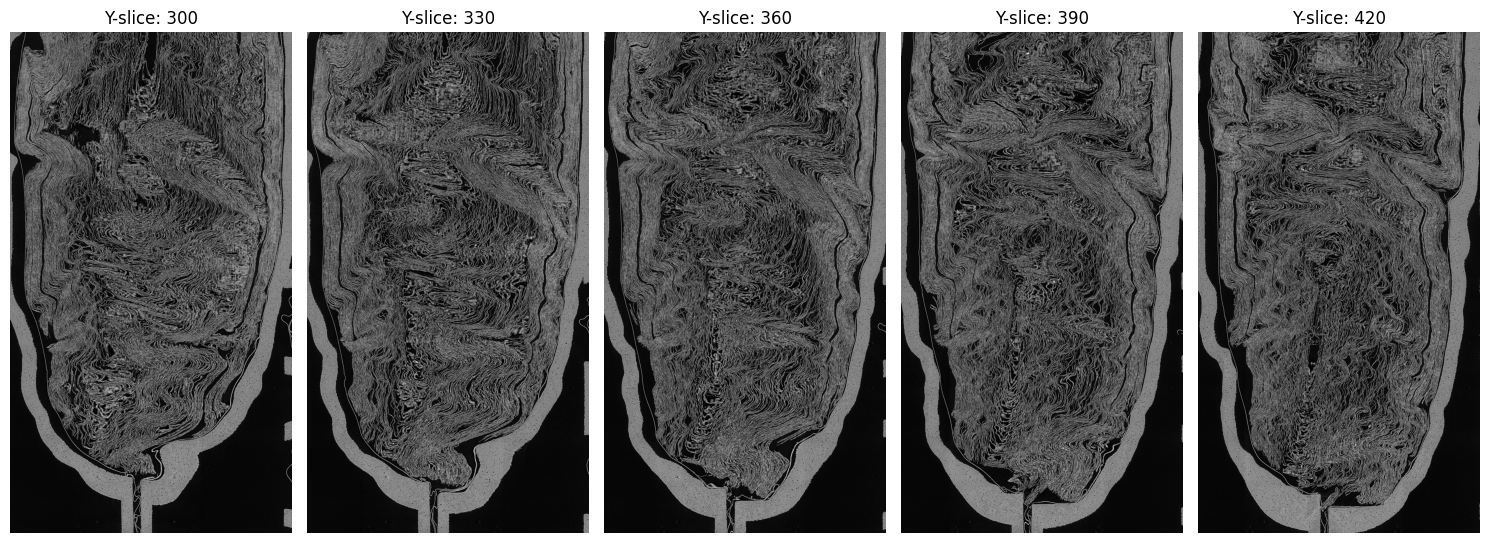

In [10]:
# Plot each slice side by side
# Create a figure with subplots
fig, axes = plt.subplots(1, num_slices, figsize=(15, 10))

slice_index = 300
for i in range(num_slices):
    current_slice = slice_index + 30*i
    axes[i].imshow(scroll[:, current_slice, :, 3], cmap='gray')
    axes[i].set_title(f'Y-slice: {current_slice}')
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## 3. Volume chunks

Instead of just 2D slices, let's grab a 3D chunk of the scroll volume.

In [17]:
scroll = Volume("Scroll1", normalize=True)  # normalize=True maps values from {0, ..., 255} -> [0,1]
chunk = scroll[1800:2000, 1000:1200, 1000:1200, 2]

One way to view the chunk is to look at its orthogonal slice planes:

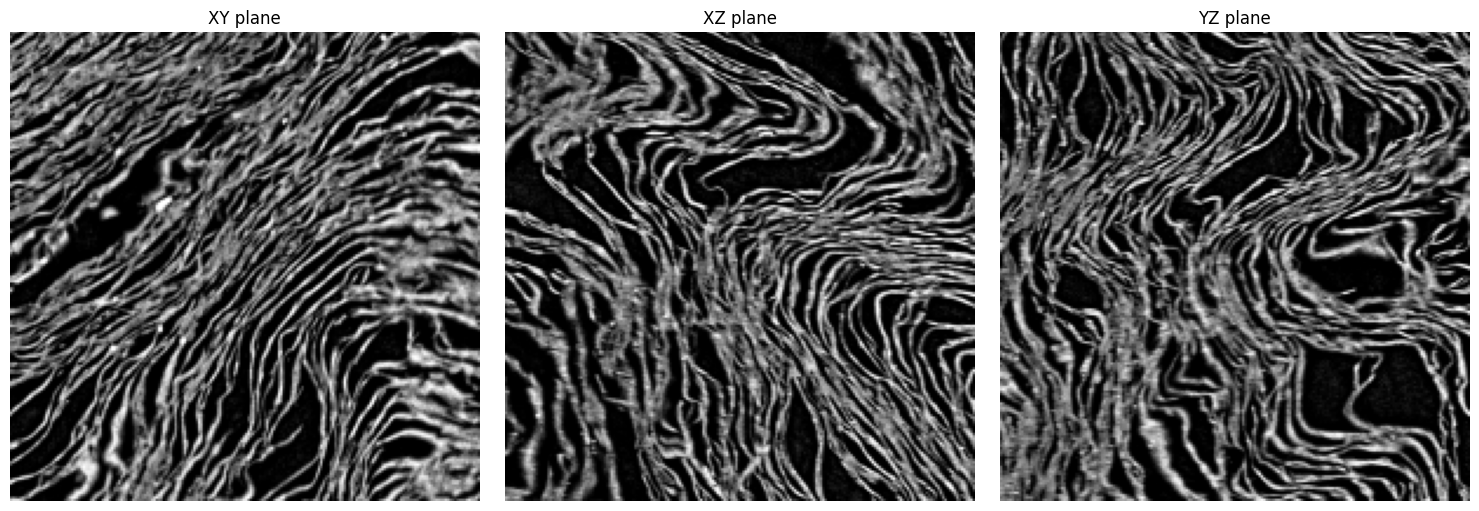

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# XY
axes[0].imshow(chunk[100, :, :], cmap='gray')
axes[0].set_title('XY plane')
axes[0].axis('off')

# XZ
axes[1].imshow(chunk[:, 100, :], cmap='gray')
axes[1].set_title('XZ plane')
axes[1].axis('off')

# YZ
axes[2].imshow(chunk[:, :, 100], cmap='gray')
axes[2].set_title('YZ plane')
axes[2].axis('off')

plt.tight_layout()
plt.show()

The brighter papyrus sheets are visible, as well as the darker air gaps between them!

We can also generate a histogram of the intensity values in the chunk:

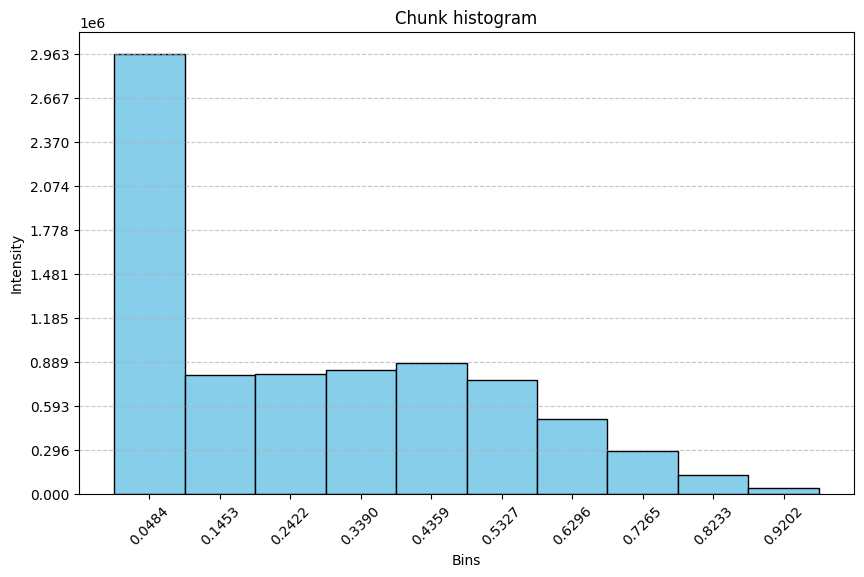

In [26]:
import numpy as np

def plot_histogram(data):
    hist = np.histogram(data)
    bin_centers = (hist[1][1:] + hist[1][:-1]) / 2

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist[0], width=(hist[1][1] - hist[1][0]), color='skyblue', edgecolor='black')

    plt.xlabel('Bins')
    plt.ylabel('Intensity')
    plt.title('Chunk histogram')

    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Customize tick marks
    plt.xticks(bin_centers, rotation=45)
    plt.yticks(range(0, max(hist[0]) + 1, max(hist[0]) // 10))

    # Show the plot
    plt.show()

plot_histogram(chunk)

What does this plot mean? In a reconstructed volumetric image from an X-ray CT scan, the intensity of every voxel is proportional to the density of the material.
We normalized the intensity in the range from 0 to 1.
The most frequent values are close to zero, meaning that air (or void) voxels are the most abundant in the volume chunk we selected.

What happens if we select another chunk, maybe around the center?

Try for yourself!

In [29]:
# Z_START = 
# Z_END = 
# Y_START =
# Y_END = 
# X_START = 
# X_END = 
# VOLUME_INDEX =

# chunk = scroll[Z_START:Z_END, Y_START:Y_END, X_START:X_END, VOLUME_INDEX]
# plot_histogram(chunk)

## 4. Segmentation proof of concept
(Skip if you are not interested in surface segmentation!)

Let us just plot a smaller portion of slice 7000 at the full resolution:

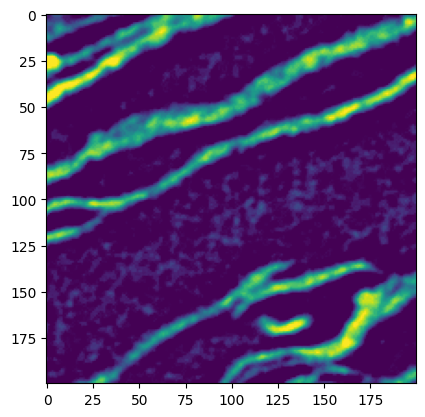

In [28]:
plt.imshow(scroll[7000,4600:4800,4000:4200])

We are going to get our hands dirty and extract a little piece of surface from this data. We will apply the following steps:

a. **Denoise**\
b. **Surface Detection**


**a. Denoise**
We are going to denoise the data to make it more easily manipulable by the surface detection in the next step. We have to do it because the surface detection leverages approximations of the gradient (local difference in voxel intensity) that can be disturbed by noise.
:


In [ ]:
!pip install scikit-image PyWavelets
from skimage.restoration import estimate_sigma, denoise_nl_means

In [30]:
# Download data chunk into numpy array
chunk = scroll[7000:7100,4600:4800,4000:4200]

# Estimate variance in the chunk
sigma = estimate_sigma(chunk)

# Denoise with non-local means using the extracted sigma
chunk = denoise_nl_means(chunk, patch_size=7, patch_distance=3, sigma=sigma, h=0.03)

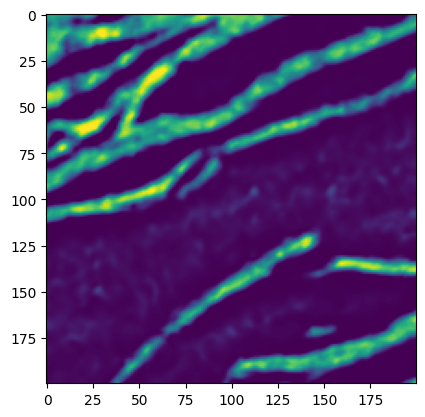

In [31]:
plt.imshow(chunk[20,:,:])

**b. Surface detection**
Let's define an algorithm to detect the surface. What we are going to use will evaluate the gradient and the hessian at every voxel in the denoised chunk and select only those voxels that have a gradient magnitude higher than a threshold AND for which the determinant of the Hessian is lower than another threshold. This helps focusing on the surface and neglecting blobs. Later, we perform Non-Maximum Suppression to make the extracted surface thin.

In [32]:
import numpy as np
from scipy.ndimage import convolve, map_coordinates

def divide_nonzero(array1, array2):
    precision = array1.dtype
    denominator = np.copy(array2)
    denominator[denominator == 0] = np.finfo(precision).tiny
    return np.divide(array1, denominator)

def calculate_det(a,b,c,d,e,f):
    det = np.abs(a*(b*c-e**2)-d*(d*c-e*f)+f*(d*e-b*f))
    return det

def normalize_gradient(a,b):
    return a/b

def grad_and_det(volume, precision):
    a = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    b = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    c = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    d = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    e = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    f = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)

    # Using Pavel Holoborodko's derivative
    pavel_1d = np.array([2,1,-16,-27,0,27,16,-1,-2], dtype=precision)  # Derivative approximation
    pavel_1d_smooth = np.array([1, 4, 6, 4, 1], dtype=precision)  # Smoothing
    pavel_1d_2nd = np.array([-7,12,52,-12,-90,-12,52,12,-7], dtype=precision)

    # Create 3D kernels by outer products and normalization
    kz = np.outer(np.outer(pavel_1d, pavel_1d_smooth), pavel_1d_smooth).reshape(9, 5, 5)/ (96*16*16)
    ky = np.outer(np.outer(pavel_1d_smooth, pavel_1d), pavel_1d_smooth).reshape(5, 9, 5)/ (96*16*16)
    kx = np.outer(pavel_1d_smooth, np.outer(pavel_1d_smooth, pavel_1d)).reshape(5, 5, 9)/ (96*16*16)
    kzz = np.outer(np.outer(pavel_1d_2nd, pavel_1d_smooth), pavel_1d_smooth).reshape(9, 5, 5)/ (192*16*16)
    kyy = np.outer(np.outer(pavel_1d_smooth, pavel_1d_2nd), pavel_1d_smooth).reshape(5, 9, 5)/ (192*16*16)
    kxx = np.outer(pavel_1d_smooth, np.outer(pavel_1d_smooth, pavel_1d_2nd)).reshape(5, 5, 9)/ (192*16*16)

    gradient = np.zeros((3, volume.shape[0], volume.shape[1], volume.shape[2]), dtype=np.float32)

    a = convolve(volume, kzz)
    b = convolve(volume, kyy)
    c = convolve(volume, kxx)

    gradient[0] = convolve(volume, kz)
    d = convolve(gradient[0], ky)
    f = convolve(gradient[0], kx)

    gradient[1] = convolve(volume, kx)
    e = convolve(gradient[1], kx)

    gradient[2] = convolve(volume, kx)

    det = calculate_det(a,b,c,d,e,f)

    del a, b, c, d, e, f

    magnitude = np.sqrt(gradient[0]**2+gradient[1]**2+gradient[2]**2)

    gradient = normalize_gradient(gradient, magnitude)

    return det, gradient, magnitude

def nms_3d(magnitude, grad):
    """
    Applies Non-Maximum Suppression on a 3D volume using interpolation along gradient directions.

    Parameters:
    - magnitude: 3D numpy array representing the magnitude of gradients.
    - grad: 3D numpy array of shape (3, *magnitude.shape) representing gradient vectors.

    Returns:
    - nms_volume: 3D numpy array after applying NMS.
    """

    # Get the shape of the volume
    z_dim, y_dim, x_dim = magnitude.shape

    # Create meshgrid of indices
    Z, Y, X = np.meshgrid(np.arange(z_dim), np.arange(y_dim), np.arange(x_dim), indexing='ij')

    # Calculate continuous indices for forward and backward positions based on gradients
    forward_indices = np.array([Z, Y, X]) + grad
    backward_indices = np.array([Z, Y, X]) - grad

    # Interpolate the magnitude values at these continuous indices
    forward_values = map_coordinates(magnitude, forward_indices, order=1, mode='nearest')
    backward_values = map_coordinates(magnitude, backward_indices, order=1, mode='nearest')

    # Apply conditions for NMS using logical functions
    condition1 = np.logical_and(magnitude >= forward_values, magnitude > backward_values)
    condition2 = np.logical_and(magnitude > forward_values, magnitude >= backward_values)
    mask = np.logical_or(condition1, condition2)

    # Apply mask to set NMS volume
    magnitude[~mask] = 0

    return magnitude

def surface_detection(volume, precision, threshold_grad=0.2, threshold_det=0.001):
    det, gradient, magnitude = grad_and_det(volume, precision)
    magnitude = nms_3d(magnitude, gradient)
    det /= det.max()
    magnitude /= magnitude.max()
    mask = (det < threshold_det) & (magnitude > threshold_grad)
    del det, gradient, magnitude
    edges = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=np.uint8)
    edges[mask] = 1
    return edges

/var/folders/pk/bt14kb_n5_bfrls62b_n32680000gn/T/ipykernel_57352/938897245.py:15: RuntimeWarning:

invalid value encountered in divide



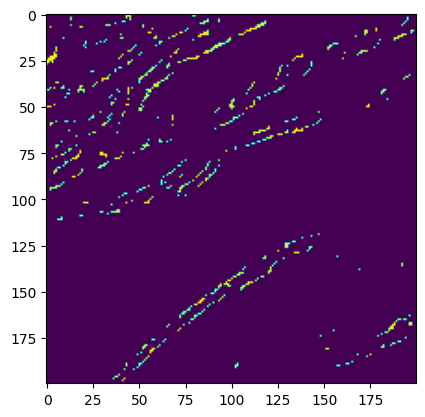

In [33]:
surface = surface_detection(chunk, np.float32)

plt.imshow(surface[20])

The previous algorithm flagged some voxels as on-surface, but we actually want only the recto surface of every sheet -- the "front side," on which text is written. To do so, we can just use the value of the gradient computed on each voxel flagged as on-surface and check that the dot product with a vector coming from the main axis of the scroll is positive. In this tutorial let's assume that this vector is just (0,-1,0).

/var/folders/pk/bt14kb_n5_bfrls62b_n32680000gn/T/ipykernel_57352/938897245.py:15: RuntimeWarning:

invalid value encountered in divide



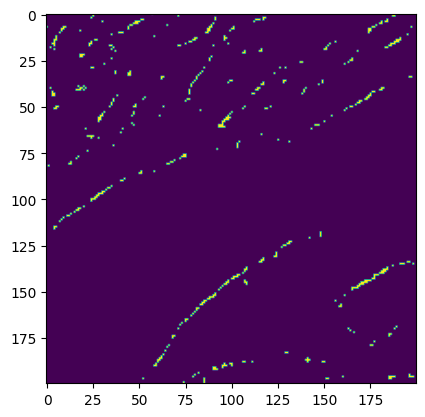

In [35]:
vector = np.array([0,-1,0], dtype=np.float32)

_, gradient, _ = grad_and_det(chunk, np.float32)

dot_product = np.einsum('xdhw,x->dhw', gradient, vector)

recto_chunk = surface & (dot_product > 0)

plt.imshow(recto_chunk[50])

Great! We have extracted some point clouds that lie on the surface of the papyrus! For a more detailed intro to segmentation please visit our tutorials: [Tutorial 3: Segmentation and Flattening](https://scrollprize.org/tutorial3) and [Tutorial 4: Segmentation for Fishermen](https://scrollprize.org/tutorial4).